# Plots MorbidCuriosityFMRI study
Plotting Striatum ROI:
two transverse slices for each contrast:

1. (Negative active>passive) > (Positive active>passive)
2. (Neg active>passive)

Z = -6 for Caudate and Z = 4 for Nacc/Putamen

In [1]:
import os.path as op
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from nilearn import plotting
from nilearn import image
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.datasets import fetch_haxby
from nilearn.regions import connected_label_regions
%matplotlib inline

/Users/lukas/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/lukas/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Some parameters:

In [2]:
ALPHA = 0.05 / 2  # bonferroni-corrected
THRESHOLD = 1 - ALPHA  # 1 - p-value

Gather data:

In [3]:
mappings = dict(stat1='actpas', stat2='pasact', stat3='act', stat4='pas')
data = dict()
for ctype in [d for d in glob('*') if op.isdir(d)]:
    
    data[ctype] = dict(wholebrain=dict())
    wholebrain_imgs = sorted(glob(op.join(ctype, '*.nii.gz')))
    for w_img in wholebrain_imgs:
        contrast = w_img.split('_')[-1].split('.')[0]
        data[ctype]['wholebrain'][mappings[contrast[1:]]] = w_img

    for masktype in ['IFG', 'Striatum']:
        
        data[ctype][masktype] = dict()
        p_imgs = sorted(glob(op.join(ctype, masktype + '_bin', '*.nii.gz')))
        t_imgs = sorted(glob(op.join(ctype, masktype + '_bin', '*bin_tstat*')))
        
        for p_img, t_img in zip(p_imgs, t_imgs):
            
            contrast = mappings[p_img.split('_')[-1].split('.')[0][1:]]
            
            t_data = nib.load(t_img).get_data()
            t_data[nib.load(p_img).get_data() <= THRESHOLD] = 0
            t_masked = nib.Nifti1Image(t_data, affine=nib.load(t_img).affine)
            
            data[ctype][masktype][contrast] = dict(
                p=p_img,
                t=t_img,
                t_masked=t_masked
            )

Atlases:

In [4]:
subc_atlas = fetch_atlas_harvard_oxford('sub-maxprob-thr0-2mm', symmetric_split=False)
cort_atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr0-2mm', symmetric_split=False)
subc_rois = ['Left Caudate', 'Right Caudate',
             'Left Putamen', 'Right Putamen',
             'Left Accumbens', 'Right Accumbens']
cort_rois = ['Inferior Frontal Gyrus, pars triangularis',
             'Inferior Frontal Gyrus, pars opercularis']

## ROI-analysis: negative (act-pas)

/Users/lukas/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/lukas/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


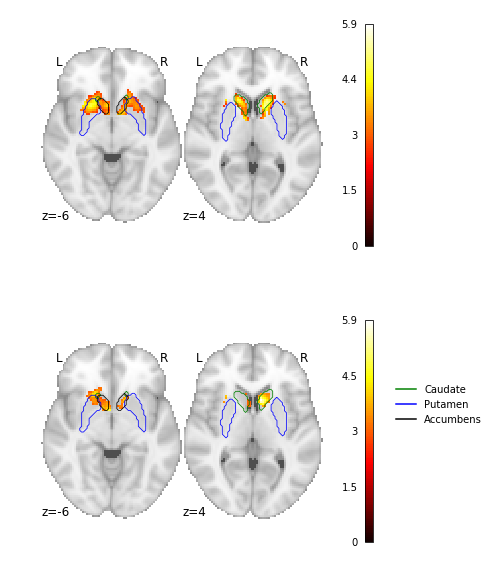

In [5]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 10))

imgs = [
    data['desc_neg']['Striatum']['actpas']['t_masked'],
    data['desc_negpos']['Striatum']['actpas']['t_masked']
]

for i, img in enumerate(imgs):
    display = plotting.plot_stat_map(
        stat_map_img=img,
        display_mode='z',
        cut_coords=[-6,4],
        colorbar=True,
        figure=fig,
        axes=axes[i]
    )
    
    contour_colors = ['green', 'green', 'blue', 'blue', 'black', 'black'] 
    atlas_map = nib.load(subc_atlas['maps']).get_data()
    for i, roi in enumerate(subc_rois):
        mask = atlas_map == subc_atlas['labels'].index(roi)
        mask = nib.Nifti1Image(mask.astype(int), affine=nib.load(subc_atlas['maps']).affine)
        display.add_contours(
            mask,
            levels=[0.1],
            colors=contour_colors[i],#'k',
            antialiased=True,
            linewidths=.75
        )

plt.legend(
    handles=[
        plt.Line2D([0], [0], color='green'),
        plt.Line2D([0], [0], color='blue'),
        plt.Line2D([0], [0], color='black')
    ],
    labels=['Caudate', 'Putamen', 'Accumbens'],
    frameon=False,
    bbox_to_anchor=(15.1, 0.75)
)

#display.savefig('figures/desc-neg_striatum.png', dpi=400)
plotting.show()
display.close()

## Wholebrain: negative, positive, conjunction
Plotting Whole brain one plot with three colours

X = 20 (saggital slice dACC), X = 46 (saggital slice IFG), Y = 69, Z = 36 for transverse and coronal slices)
a.	Neg active > passive 
File: FEAT, Cope1, thresh_zstat_1.nii.gz
b.	Pos active > passive 
File: FEAT, Cope2, thresh_zstat_1.nii.gz
c.	Conjunction: neg active > passive  && pos active > passive

/Users/lukas/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/lukas/anaconda3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


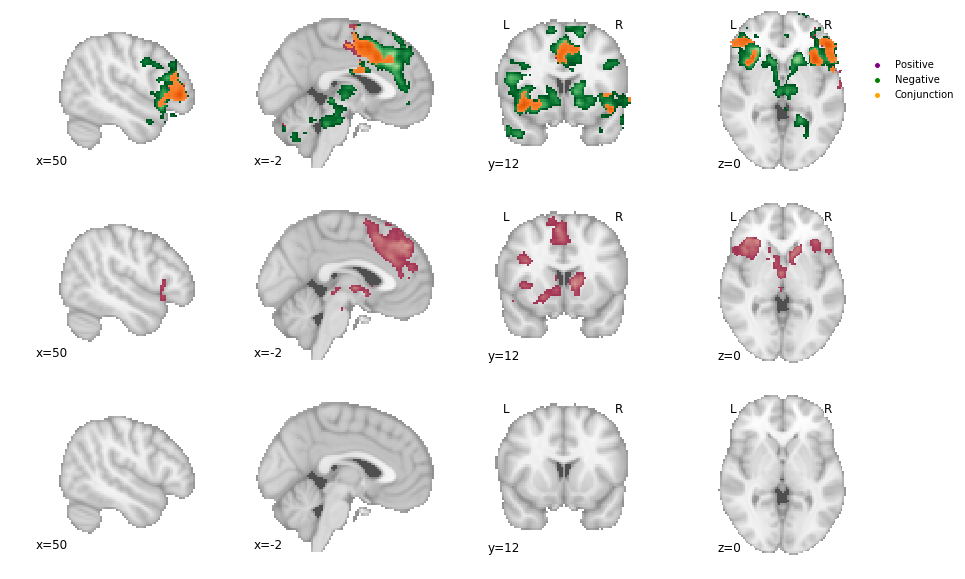

In [6]:
### Plotting the whole-brain analysis, with the conjunction. Be aware that this file should change!
wb_neg = data['desc_neg']['wholebrain']['actpas']
wb_pos = data['desc_pos']['wholebrain']['actpas']
wb_negpos = data['desc_negpos']['wholebrain']['actpas']
wb_posneg = data['desc_posneg']['wholebrain']['actpas']

wb_conj = 'thresh_conjunction_cue-negpos_contrast-actpas.nii.gz'

coords = [('x', 50), ('x', -2), ('y', 12), ('z', 0)]
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

for i in range(axes.shape[1]):

    display = plotting.plot_stat_map(
        stat_map_img=wb_pos,
        display_mode=coords[i][0],
        cut_coords=[coords[i][1]],
        threshold=2.58,
        vmax=8,
        cmap='purple_green_r',
        colorbar=False,
        draw_cross=False,
        figure=fig,
        axes=axes[0, i]
    )

    display.add_overlay(
        wb_neg,
        threshold=2.58,
        vmax=7,
        vmin=-2,
        cmap='purple_green'
    )

    display.add_overlay(
        wb_conj,
        threshold=2.58,
        vmax=7,
        vmin=-2,
        cmap='Oranges'
    )
    
    display = plotting.plot_stat_map(
        stat_map_img=wb_negpos,
        display_mode=coords[i][0],
        cut_coords=[coords[i][1]],
        threshold=2.58,
        vmax=8,
        cmap='purple_green_r',
        colorbar=False,
        draw_cross=False,
        figure=fig,
        axes=axes[1, i]
    )
    
    display = plotting.plot_stat_map(
        stat_map_img=wb_posneg,
        display_mode=coords[i][0],
        cut_coords=[coords[i][1]],
        threshold=2.58,
        vmax=8,
        cmap='purple_green_r',
        colorbar=False,
        draw_cross=False,
        figure=fig,
        axes=axes[2, i]
    )

axes[0, 3].legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='purple'),
        plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='green'),
        plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='orange'),   
    ],
    labels=['Positive', 'Negative', 'Conjunction'],
    frameon=False,
    bbox_to_anchor=(1.5, 0.75)
)

plotting.show()
display.close()